<img align="center" src="../extra/logos/logos.png" width='1200px'>

# Uso intermedio de Data Cube para proyecciones de fiscalización en otros contextos
***
## Tutorial de uso paquete samsara en Data Cube Chile

Bienvenidos a este tutorial para el uso de la [librería samsara](https://github.com/Data-Observatory/lib-samsara/tree/main) en Data Cube Chile.

En esta sesión revisaremos cómo el proyecto SAMSARA logra la detección de cambios negativos en matorrales y bosques en un sector de la región Metropolitana.

Primero, debemos cerciorarnos de que tenemos replicado (clonando) el repositorio de entrenamiento básico: https://github.com/Data-Observatory/DataCubeTraining. Es primordial que este repositorio esté ya en la sesión de cada uno. Si no está, se puede descargar ejecutando lo siguiente en la consola `git clone https://github.com/Data-Observatory/DataCubeTraining.git`

Segundo, descargamos la librería a nuestro local. Procurar hacer esto estando dentro de la carpeta `DataCubeTraining
/intermedio` con el siguiente código (¡esto solo debe ejecutarse una vez!):

In [1]:
!git clone https://github.com/Data-Observatory/lib-samsara.git

Cloning into 'lib-samsara'...
remote: Enumerating objects: 1226, done.
remote: Counting objects: 100% (551/551), done.
remote: Compressing objects: 100% (301/301), done.
remote: Total 1226 (delta 208), reused 404 (delta 185), pack-reused 675
Receiving objects: 100% (1226/1226), 2.05 MiB | 5.46 MiB/s, done.
Resolving deltas: 100% (593/593), done.


Y luego, para utilizar las funciones de la librería, ejecutaremos la siguiente celda.

In [2]:
import sys
sys.path.append('lib-samsara/src')

***
## Librerías requeridas
En primer lugar utilizaremos las siguientes librerías

In [3]:
import xarray as xr
import rioxarray
import rasterio as rio
from rasterio.enums import Resampling
from dea_tools.classification import predict_xr
import datacube
from datacube.utils import masking
import dask.array as da
import numpy as np
import math
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from scipy.ndimage import convolve
import joblib
import matplotlib.pyplot as plt
from pathlib import Path

from dea_tools.plotting import display_map
from datacube.utils.rio import configure_s3_access
from dask.distributed import Client, LocalCluster
from dask_gateway import Gateway

***
## Configuración inicial
Luego, configuraremos el acceso a imágenes de Data Cube Chile en Amazon Web Services.

In [4]:
cluster = LocalCluster()
client = Client(cluster)
configure_s3_access(aws_unsigned=False, requester_pays=True, client = client)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 29.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39435,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 29.00 GiB
Comm: tcp://127.0.0.1:44361,Total threads: 2
Dashboard: http://127.0.0.1:39483/status,Memory: 7.25 GiB
Nanny: tcp://127.0.0.1:46521,


> **Nota:** ¿Quieres ver un dashboard donde se muestre el progreso realizado?: ingresa al siguiente enlace `https://hub.datacubechile.cl/user/USUARIO/proxy/8787/status` reemplazando `USUARIO` por tu nombre de usuario.
Posiblemente debas reemplazar el puerto `8787` por algúno que entregue el cliente donde dice `dashboard`, después del `:` y antes del `/status`

***
## Área de interés
Ahora, definiremos la extensión del área de estudio.

En el transcurso del notebook veremos que hay distintos radios asociado a los vecindarios o kernels. 
Estos están definidos en la siguiente celda con el objetivo de aplicar un buffer al área de interés.
De esta manera, utilizaremos Data Cube Chile para obtener las imágenes una zona, que contiene la totalidad de pixeles requeridos en los procesos de filtro o convolución.

In [5]:
neighbor_radius = 50
smooth_radius = 15
glcm_radius = 7
max_radius = np.max(np.array([neighbor_radius, smooth_radius, glcm_radius])) + 5
print(max_radius)

55


In [6]:
poly = gpd.read_file("denuncias.gpkg").to_crs(epsg = "32719")
poly = poly[poly.id == 431] # Solo Poligono de Peñalolen
buf_poly = poly.buffer(distance = 30*max_radius) # 5 pixeles de 30x30 resolucion.

In [7]:
xmin, ymin, xmax, ymax = buf_poly.total_bounds.round(1)
print(xmin, ymin, xmax, ymax)

356744.0 6291078.8 360563.9 6295050.4


In [8]:
x0, y0, x1, y1 = buf_poly.to_crs(epsg = "4326").total_bounds
display_map((x0, x1), (y0, y1))

***
## Serie de tiempo de NDVI
Utilizando la extensión del polígono obtenemos la serie de tiempo de las bandas `red`, `nir08` y `qa_pixel`, en los productos Landsat 5, 7, 8 y 9.

In [9]:
dc = datacube.Datacube(app="areas")
query = {"product": ['landsat5_c2l2_sr', 'landsat7_c2l2_sr', "landsat8_c2l2_sr", 'landsat9_c2l2_sr'],
         "measurements": ['red', 'nir08', 'qa_pixel'],
         "x": (xmin, xmax),
         "y": (ymin, ymax),
         "time": ("2010-01-01", "2024-01-07"),
         "output_crs": 'EPSG:32719',
         "crs": 'EPSG:32719',
         "resolution": (-30,30),
         "group_by": 'solar_day',
         "dask_chunks": {"x": 2048, "y": 2048},
         "skip_broken_datasets": True}
ds = dc.load(**query)

# Hacerlo antes de computar evita un costoso rechunk después
ds = ds.chunk({'x':50, 'y':50, 'time':len(ds.time.values)})

<br />

Definimos la siguiente siguiente función `mask_and_compute` para filtrar nubes, escalar valores a reflectancia, y obtención de NDVI.

In [10]:
def mask_and_compute(ds):
    reflectance_bands = ["red", "nir08"]
    quality_band = 'qa_pixel'
    good_pixel_flags = {
        "snow": "not_high_confidence",
        "cloud": "not_high_confidence",
        #"cirrus": "not_high_confidence",
        "cloud_shadow": "not_high_confidence",
        "nodata": False
    }

    cloud_free_mask = masking.make_mask(ds[quality_band], **good_pixel_flags)
    masked = ds[reflectance_bands].where(cloud_free_mask)
    masked.update(masked*0.0000275 + -0.2)
    ndvi = (masked.nir08 - masked.red) / (masked.nir08  + masked.red )
    ndvi = ndvi.where((ndvi > -1) & (ndvi < 1))
    ndvi.attrs = ds.attrs

    return ndvi

In [11]:
ndvi = mask_and_compute(ds.rio.clip(buf_poly.geometry.values, buf_poly.crs)).persist()

<br />

Observamos que el `ndvi` tiene 3 dimensiones, `time` con más de 560 valores `y` con 132 valores, y` x` con 128 valores.

In [12]:
ndvi

<xarray.DataArray (time: 561, y: 132, x: 128)>
dask.array<where, shape=(561, 132, 128), dtype=float32, chunksize=(561, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2010-01-06T14:25:03.486099 ... 2023-12...
  * y            (y) float64 6.295e+06 6.295e+06 ... 6.291e+06 6.291e+06
  * x            (x) float64 3.567e+05 3.568e+05 ... 3.605e+05 3.606e+05
    spatial_ref  int64 0
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

<br />

También observamos que `ndvi` fue "cortado" al buffer asociado al polígono de interés.

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


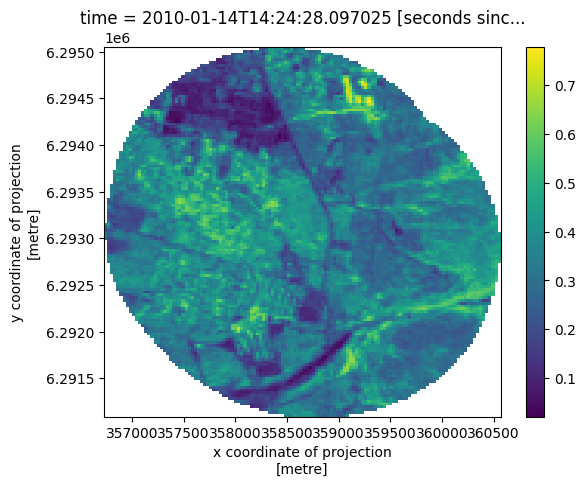

In [13]:
ndvi.isel(time = 1).plot()

***
## PELT - Detección de cambios a nivel de píxeles
En esta sección utilizaremos una implementación del algoritmo "Linearly penalized segmentation" del paquete [rupture](https://centre-borelli.github.io/ruptures-docs/).
Esta implementación detecta los cambios píxel a píxel en un objeto xarray.DataArray.

Para cargar las funciones requeridas debemos ejecutar la siguiente celda:

In [14]:
import samsara.pelt as spelt

Los parámetros que utilizaremos en PELT son:
* min_size: 3  - Implica que deben existir al menos 3 elementos (`time`) entre un `bkp` y otro.
* jump: 1      - Es la única opción para el modelo "rbf"

Otros parámetros que utilizaremos son:
* n_breaks: 5                 - Definimos un máximo de 5 `bkp`s, 
* start_date: "2016-01-01"    - Solo se guardan los `bkp`s que ocurran desde "2016-01-01" en adelante (pero se usa la serie completa para entrenar PELT)

In [15]:
# rupture parameters
model = "rbf"
min_size = 3
jump = 1
penalty = 30

# samsara parameters
n_breaks = 5
start_date = "2016-01-01"

<br />
Para ejecutar PELT utilizamos la siguiente celda 

In [16]:
fpelt = spelt.pelt(
    array = ndvi,
    n_breaks=n_breaks, 
    penalty=penalty, 
    start_date=start_date,
    model=model,
    min_size=min_size,
    jump = 5,
    backend = 'xarray') #TODO: test with 'dask'

<br />

La ejecución anterior genera el objeto `fpelt` como `future`, es decir, aún no se ha ejecutado, pero nos da una idea de cómo es su estructura:

In [17]:
fpelt

<xarray.Dataset>
Dimensions:      (y: 132, x: 128, bkp: 5)
Coordinates:
  * y            (y) float64 6.295e+06 6.295e+06 ... 6.291e+06 6.291e+06
  * x            (x) float64 3.567e+05 3.568e+05 ... 3.605e+05 3.606e+05
    spatial_ref  int64 0
  * bkp          (bkp) int64 0 1 2 3 4
Data variables:
    magnitude    (y, x, bkp) float64 dask.array<chunksize=(49, 50, 5), meta=np.ndarray>
    date         (y, x, bkp) float64 dask.array<chunksize=(49, 50, 5), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

* El objeto de salida es un `xarray.Dataset` con 2 variables `magnitude` y `date`.
    * La variable `magnitude` corresponde al delta de `ndvi` después vs antes del `bkp`.
    * La variable `date` corresponde a la fecha en la cual ocurre el `bkp` (`datetime64[s]` guardado como `float64`).
* Tiene 3 dimensiones `y`, `x`, y `bkp`.
    * Las dimensiones `y` y `x` corresponden a las mismas dimensiones `y` y `x` del objeto de entrada `ndvi`.
    * La dimensión `bkp` tiene 5 elementos, debido al argumento `n_breaks`.

Para ejecutar el objeto `fpelt` y guardar sus resultados en memoria debemos correr la siguiente línea, donde `%time` se agrega para conocer el tiempo que demora la ejecución.

In [18]:
%time pelt_output = fpelt.compute()

CPU times: user 1.14 s, sys: 183 ms, total: 1.32 s
Wall time: 27.6 s


<br />

Podemos graficar los resultados de `pelt_output`

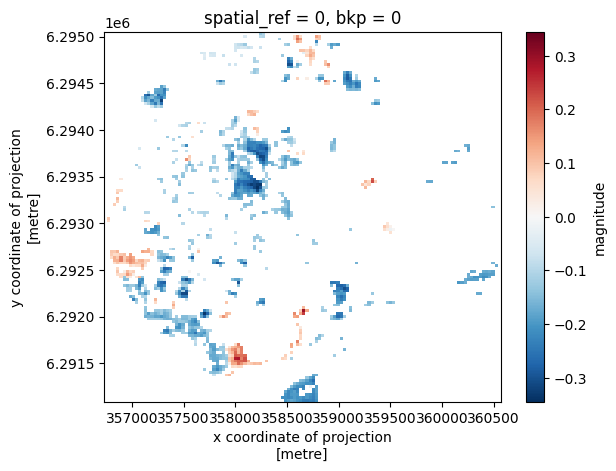

In [19]:
pelt_output.magnitude.isel(bkp = 0).plot()

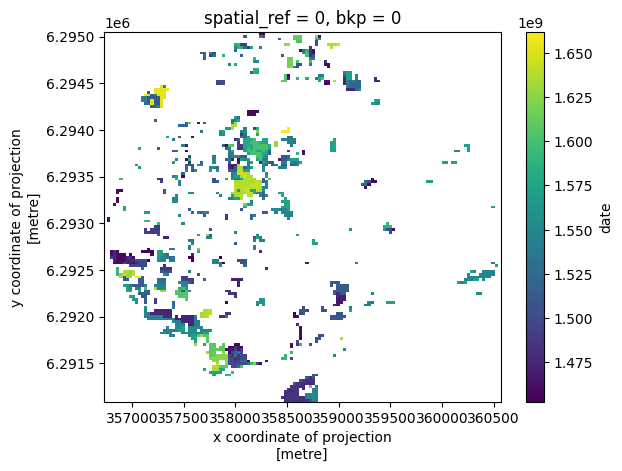

In [20]:
pelt_output.date.isel(bkp = 0).plot()

<br />

No parece muy fácil de interpretar el gráfico anterior debido al rango de valores de `date`. Para corregir esto debemos utilizar la función `spelt.datetime_to_year_fraction` como en la siguiente celda

In [21]:
## Obtener dates in year.decimals
pelt_output.date.data = spelt.datetime_to_year_fraction(pelt_output.date.data.astype('datetime64[s]'))

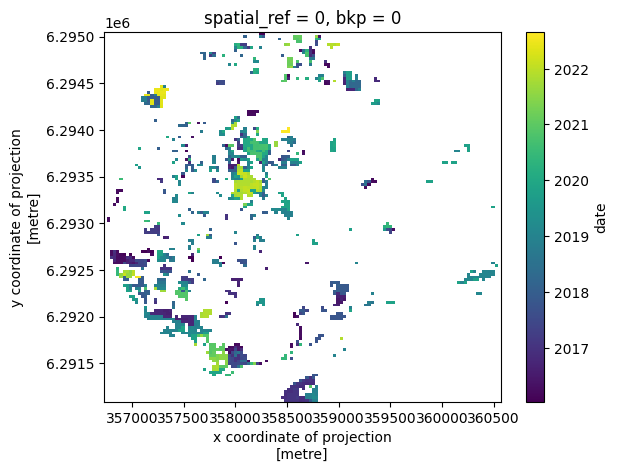

In [22]:
pelt_output.date.isel(bkp = 0).plot()

***
## Neighborhood statistics - Estadísticas de vecindario

Las estadísticas de vecindario corresponde a la ejecución de un filtro (convolución), en la cual se recorre una imagen píxel a píxel, se extrae un kernel o vecindario, se computan ciertas funciones y se asigna el resultado al píxel central del kernel.

En esta sección obtendremos dos estadísticas de vecindario, la desviación estándar de las fechas y el conteo de píxeles con fechas. Esto con un kernel cuadrado de radio 50.

Para cargar las funciones requeridas debemos ejecutar la siguiente celda:

In [23]:
import samsara.filter as sfilter
import samsara.stats.neighborhood as sns

<br />

Debido a la naturaleza del proyecto, interesan los píxeles con deltas de `ndvi` negativos. Asimismo, interesan los píxeles con el último delta `ndvi` negativo detectado por PELT.

Ejecutaremos la siguiente celda para obtener el último delta de `ndvi` negativo y su fecha:

In [24]:
pelt_filtered = sfilter.filter_by_variable(pelt_output, filter_type = 'last_negative', variable = 'magnitude').chunk({'x':75, 'y':75})
pelt_filtered

<xarray.Dataset>
Dimensions:      (y: 132, x: 128)
Coordinates:
  * y            (y) float64 6.295e+06 6.295e+06 ... 6.291e+06 6.291e+06
  * x            (x) float64 3.567e+05 3.568e+05 ... 3.605e+05 3.606e+05
    spatial_ref  int64 0
Data variables:
    magnitude    (y, x) float64 dask.array<chunksize=(75, 75), meta=np.ndarray>
    date         (y, x) float64 dask.array<chunksize=(75, 75), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

En el resultado de la celda anterior nos indica que se mantienen tanto las variables `magnitude` y `date`, asi como las dimensiones `y` y `x`. Sin embargo, ya no contamos con la dimensión `bkp`.

Con el objeto `pelt_filtered` utilizamos las funciones `sns.stats` para obtener estadísticas de vecindario. El argumento `kernel` permite definir el vecindario, si se entrega un entero, el vecindario será un kernel cuadrado de radio igual al entero entregado.

Podemos ejecutar la siguiente celda para generar los objetos requeridos:
> Recordemos que `neighbor_radius` tiene un valor de 50.

In [25]:
date_std = sns.stats(pelt_filtered, stat = "std", kernel = neighbor_radius, variable = 'date')
date_cnt = sns.stats(pelt_filtered, stat = "count", kernel = neighbor_radius, variable = 'date')

<br />

Adicionalmente, vamos a guardar tres resultados en un `xarray.Dataset` llamado `inputImg`. 

Estos resultados son `pelt_filtered.magnitude`, `date_std` y `date_cnt`.

In [26]:
inputImg = pelt_filtered.magnitude.to_dataset(name = 'magnitude', promote_attrs = True)
inputImg[['ngbh_stdev']] = date_std
inputImg[['ngbh_count']] = date_cnt

<br />
Podemos observar estas variables de manera gráfica

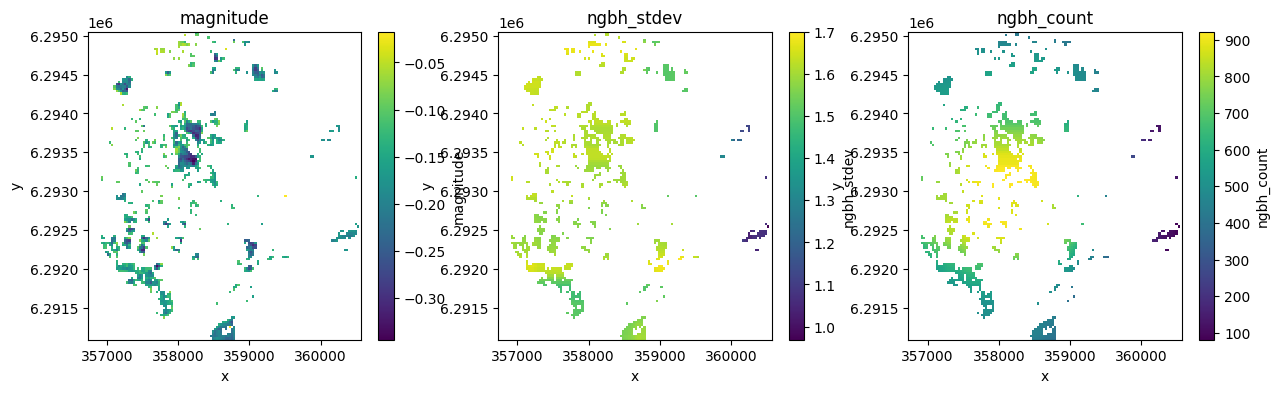

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, var in enumerate(inputImg.data_vars):
    inputImg[var].plot(ax=axes[i])
    axes[i].set_title(var)

***
## GLCM

En esta sección calcularemos 7 métricas de texturas desde la matriz *Gray-Level Co-occurrence Matrix (GLCM)*. La librería [SAMSARA](https://github.com/Data-Observatory/lib-samsara) utiliza una implementación de GLCM de [scikit-image](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_glcm.html), pero aplicado un filtro con un `kernel` cuadrado de radio 7 y cuya función es calcular GLCM y sus texturas.

Para cargar las funciones requeridas debemos ejecutar la siguiente celda:

In [28]:
import samsara.kernel as skernel
import samsara.stats.glcm as sglcm

### Suavizamiento previo
Previo a la obtención de las texturas se adoptó un proceso de suavizado de las magnitudes negativas de `NDVI`. Este suavizado consiste en la ejecución de un filtro circular de media de radio 15. Luego, para cada pixel, si el valor absoluto de la sustracción entre el `NDVI` y el resultado filtrado es mayor que 0.2, se utiliza el resultado filtrado, en caso contrario se mantiene el valor original de `NDVI`.

Primero, generamos el kernel circular de radio 15 ejecutando la siguiente celda:

In [29]:
r15_circle_kernel = skernel.circle(smooth_radius)

<br />
Podemos explorar la forma del kernel ejecutando la siguiente celda:

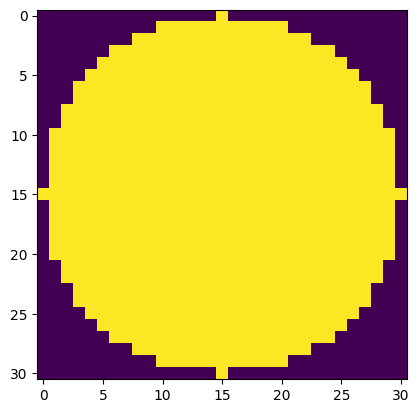

In [30]:
plt.imshow(r15_circle_kernel.data, interpolation='none')
plt.show()

<br />

Similar a lo revisado en estadísticas de vecindarios, utilizamos `sns.stats` para obtener el filtro de media para el kernel circular.

In [31]:
focal =  sns.stats(inputImg, stat = "mean", kernel = r15_circle_kernel, variable = 'magnitude')

<br />
Posteriormente aplicamos el suavizado ejecutando la siguiente celda:

In [32]:
pelt_filtered_magnitude_smooth = focal.where(abs(inputImg.magnitude - focal) > 0.2, other=inputImg.magnitude)

<br />

Podemos observar el resultado de la suavización de manera gráfica:

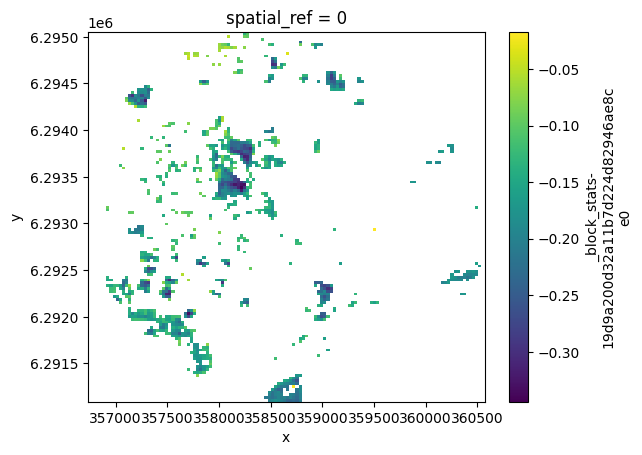

In [33]:
pelt_filtered_magnitude_smooth.plot()

### Transformación de valores

Ahora, debemos transformar el objeto anterior a valores enteros para que sean utilizados en GLCM. 
Para esto utilizamos la función `xr_transform` definida en la siguiente celda, y definimos 8 niveles distintos. Si el archivo tiene `nan`s serán 9 niveles, reservando un nivel para los `nan`s y luego excluyendolos de la matrix de co-ocurrencia de valores grises a través del argumento `nan_supression = 3`.

In [34]:
def xr_transform(xarray, levels, dtype = None):
    # Esta función reduce la resolución radiométrica de la imagen
    xr = xarray.copy()
    if dtype is None:
        dtype = xarray.dtype
    min = np.nanmin(xr.data)
    max = np.nanmax(xr.data)
    zi = (xr - min) / (max - min)
    li = (zi*(levels - 1))
    if xr.isnull().any().data == True:
         li = np.nan_to_num(li + 1)
    xr.data = li.round().astype(dtype)
    return(xr)

In [35]:
levels = 2**3
if (pelt_filtered_magnitude_smooth.isnull().any().data):
    new_levels = int(levels + 1)
else:
    new_levels = int(levels)
        
data3 = xr_transform(pelt_filtered_magnitude_smooth, levels = levels, dtype = 'uint8')

<br />

Podemos observar el resultado de la transformación de manera gráfica:

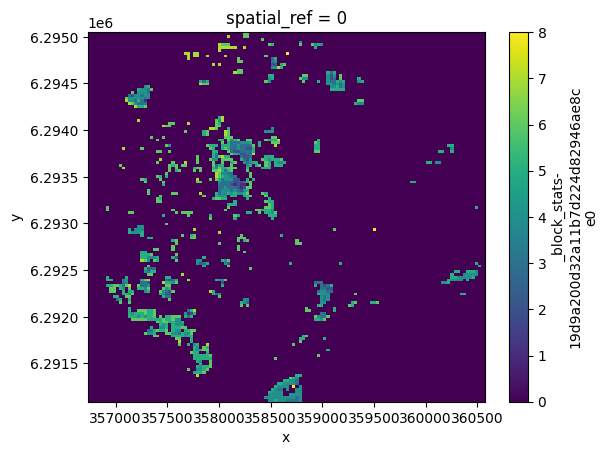

In [36]:
data3.plot()

### Aplicación de GLCM

Ya hemos generado el archivo de entrada para obtener las texturas de GLCM, ahora debemos definir:
* radio del kernel - debe ser mayor o igual a la mayor distancia. Fue previamente definido en `glcm_radius`
* distancias - número de píxeles desde el centro del kernel que se utilizarán para calcular la matriz de co-ocurrencia de valores grises para cada ángulo.
* ángulos - hacia dónde se calcularán los GLCM para cada distancia. Los ángulos se entregan en radianes, con valor cero hacia el Este y aumentando en sentido anti-horario.

In [37]:
distances = [1, 4, 7]
angles = [0*(math.pi/4), 1*(math.pi/4), 2*(math.pi/4), 3*(math.pi/4)]

<br />

Además, definiremos otros parámetros para el calculo de GLCM y texturas:
* symmetric: True - Parámetro interno de [GLCM de skimage](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.graycomatrix). Si `symmetric` es True, se ignora el orden de los pares de valores, siendo el píxel (i, j) y (j, i) contados cuando se pide (i, j). Esto ayuda a disminuir la intensidad de cómputo y por esto no se calculan las co-ocurrencias todas las direcciones.
* normed: True - Parámetro interno de [GLCM de skimage](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.graycomatrix). Si `normed` es True, cada matriz P[:, :, d, theta] es dividida por el número acumulado de co-ocurrencias, resultando en una matriz que suma 1.

* skip_nan: True - Parámetro de samsara. Si `skip_nan` es True, y el pixel central de un kernel tiene valor cero, asigna `nan` al resultado de las texturas.
* nan_supression: 3 - Parámetro de samsara. 
    * Si `nan_supression` es 0, mantiene los valores de la matriz de co-ocurrencias.
    * Si `nan_supression` es 1, reasigna el valor del primer elemento de la matriz de co-ocurrencias a 0. El primer elemento corresponde a la intersección de la primera fila y la primera columna.
    * Si `nan_supression` es 2, reasigna el valor de la primera fila y la primera columna de la matriz de co-ocurrencias a 0.
    * Si `nan_supression` es 3, elimina la primera fila y columna de la matriz de co-ocurrencias. Recomendado si se reserva un nivel para `nan`s 
* rescale_normed: True - Parámetro de samsara. Si `normed` es True, re-escala los valores de cada matrix de co-ocurrencia luego de utilizar `nan_supression` para que vuelva a resultar en una matriz que suma 1.

Estos parámetros se guardaran en un diccionario llamado `mb_kwargs`, al ejecutar la siguiente celda:

In [38]:
mb_kwargs = {
    'distances' : distances,
    'angles' : angles,
    'levels' : new_levels,
    'symmetric' : True,
    'normed' : True,
    'skip_nan' : True,
    'nan_supression' : 3,
    'rescale_normed' : True,
}

<br />

Luego, se calculan las texturas al ejecutar la siguiente celda:

In [39]:
glcm = sglcm.glcm_textures(data3, radius = glcm_radius, n_feats = 7, **mb_kwargs)

<br />

Observamos que `glcm`, tiene 3 dimensiones, `prop`, `y`, y `x`.
Los elementos de `prop` son:
* `asm` o segundo momento angular: Representa la uniformidad de distribución de niveles grises en la imagen (kernel), varía desde el inverso del cuadrado del total de niveles de grises hasta 1, donde 1 representa una imagen constante.
* `contrast` o contraste: Es una medida de variación local presente en una imagen (kernel) y varía desde 0 hasta el número total de niveles de grises menos uno al cuadrado, donde un contraste alto representa una alta variación.
* `corr` o correlación: Es una medida de la dependencia linear de valores grises con respecto a píxeles vecinos.
* `var` o varianza: Medida de heterogeneidad de niveles grises en la imagen.
* `idm` o  momento diferencial inverso: Mide la homogeneidad local de una imagen (kernel), valores altos representan mayor homogeneidad.
* `savg` o suma promedio: Es la media de las sumas de pixeles que co-ocurren en la imagen (kernel).
* `entropy` o entropía: Es una medición estadística de aleatoridad y varía desde 0 hasta infinito.

In [40]:
glcm

<xarray.DataArray (prop: 7, y: 132, x: 128)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * prop         (prop) <U8 'asm' 'contrast' 'corr' 'var' 'idm' 'savg' 'entropy'
  * y            (y) float64 6.295e+06 6.295e+06 ... 6.291e+06 6.291e+06
  * x            (x) float64 3.567e+05 3.568e+05 ... 3.605e+05 3.606e+05
    spatial_ref  int64 0

<br />

Podemos visualizar los resultados a través del código de la siguiente celda, donde el primer elemento corresponde a los niveles de grises que entraron a la función de GLCM y, el resto de los elementos son las textura calculadas.

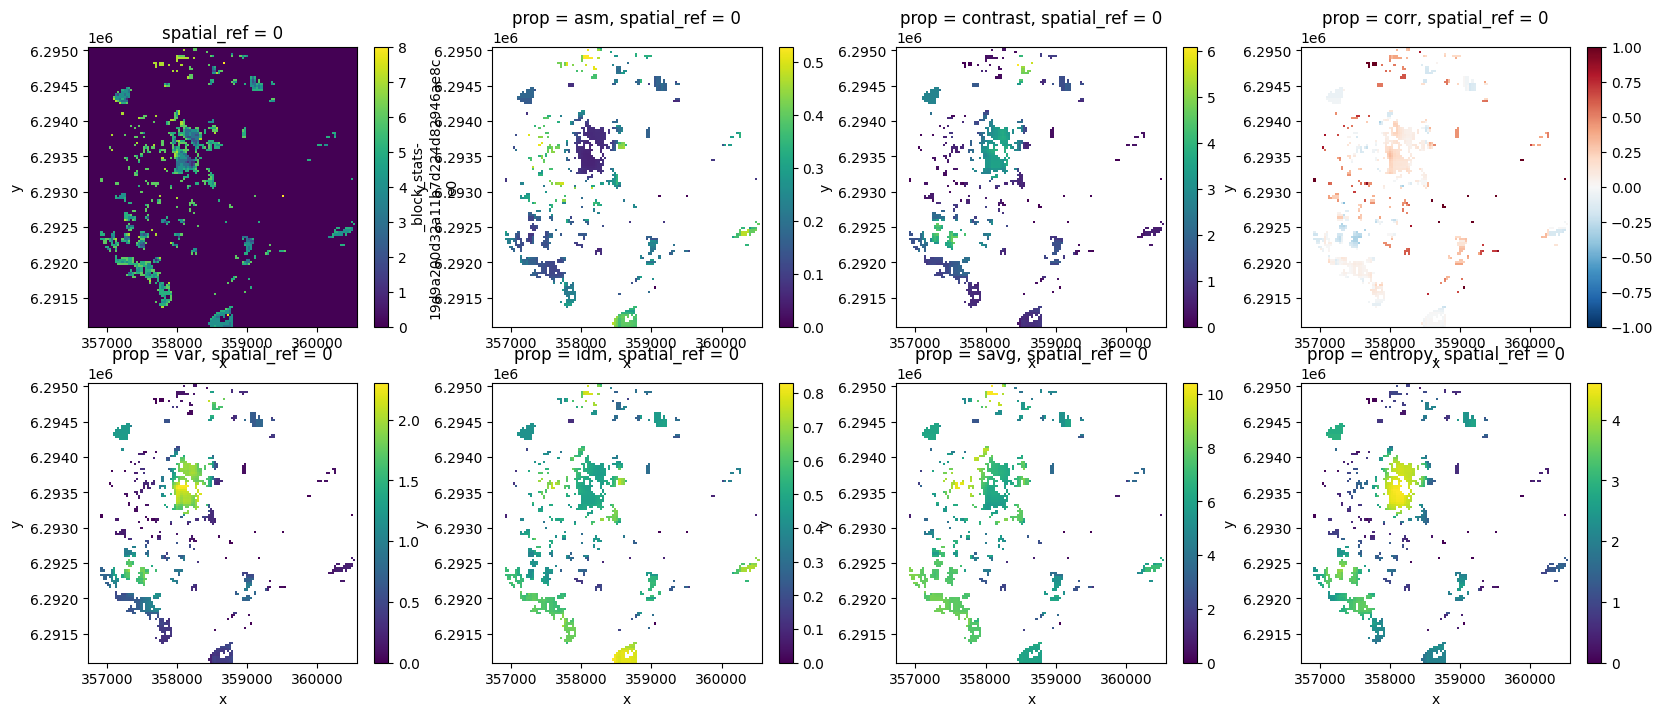

In [41]:
f, axs = plt.subplots(2, 4, sharey=False, figsize=(20, 8))
data3.plot(ax = axs[0,0])
for count, elem in enumerate(glcm):
    elem.plot(ax = axs[(count+1)//4, (count+1)%4])

<br />

Al igual que en la sección anterior, vamos a guardar estos resultados en el `xarray.Dataset` llamado `inputImg`.

In [42]:
inputImg = xr.merge([inputImg, glcm.to_dataset(dim="prop", promote_attrs=True)])

***
## Aplicación del modelo Random Forest

Se utilizó el paquete de sklearn para entrenar un modelo de [clasificación de Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

El modelo ya fue entrenado, y podemos cargarlo usando la siguiente celda:

In [43]:
rf_model = "RF_v03_all-trained_negative_of_first.joblib"
nname = rf_model.split(".")[0]
classifier = joblib.load(rf_model)

<br />

El paquete sklearn no funciona directamente con xarray. Afortunadamente la función `predict_xr` disponible en `dea_tools` permite ejecutar el modelo en un `xarray.Dataset` que contenga los nuevos datos.

In [44]:
inputImgf = inputImg.chunk({"x": 100, "y": 100})
classified = predict_xr(model = classifier, 
                        input_xr = inputImgf, 
                        clean=True).rename(name_dict = {"Predictions": "y_predict"}).compute()
classified.attrs = inputImg.attrs

predicting...


/env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


<br />

Podemos explorar los resultados de `classified`, que entrega un `xarray.Dataset` con `y_predict` como variable

In [45]:
classified

<xarray.Dataset>
Dimensions:      (x: 128, y: 132)
Coordinates:
  * x            (x) float64 3.567e+05 3.568e+05 ... 3.605e+05 3.606e+05
  * y            (y) float64 6.295e+06 6.295e+06 ... 6.291e+06 6.291e+06
    spatial_ref  int32 32719
Data variables:
    y_predict    (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

<br />

Podemos visualizar este resultado de manera espacial ejecutando la siguiente celda

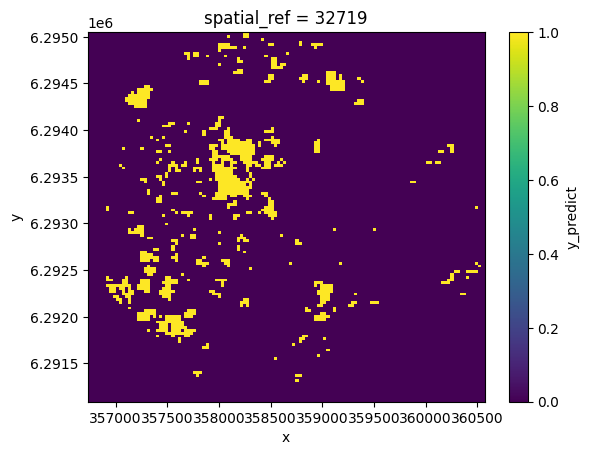

In [46]:
classified.y_predict.plot()

***
## Máscara por LandCover

Utilizaremos un LandCover para excluir aquellas áreas que no sean de interés, es decir, que no sean ni matorrales ni bosque.

Con la siguiente celda podemos cargar un tif con el LandCover con valores 1 en áreas de interés y valores 0 en áreas a excluir.

La función `reproject` se encarga de cambiar el sistema de referencia de coordenadas, alinear los raster, remuestrearlos, y recortarlos a la extensión de los datos objetivos.

In [47]:
# máscara por landcover especial y alinear a classified
# lc_ = xr.load_dataset("LC_mix_matybosquenat2013-2014_cog.tif", engine="rasterio").band_data.squeeze()
lc_ = xr.load_dataset("LC_union_4y7_cog.tif", engine="rasterio").band_data.squeeze()
lc = lc_.rio.reproject(inputImg.rio.crs,
                            transform=inputImg.rio.transform(),
                            shape=inputImg.rio.shape,
                            resampling = Resampling.nearest)

<br />

El landcover que se utilizará de máscara se puede visualizar en la siguiente celda:

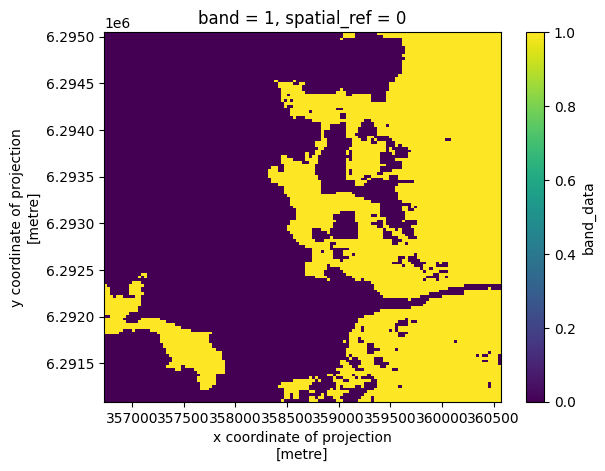

In [48]:
lc.plot()

<br />

La siguiente celda ejecuta la máscara y entrega 3 objetos:
* sam_bool: es el booleano de sí hay cambio (1), y no hay cambio (0).
* sam_mgs: es el delta ndvi del último negativo registrado.
* sam_dates: es la fecha en la cual se registro el último delta ndvi negativo.

In [49]:
## Lugares con cambios
sam_bool = xr.where((inputImg.magnitude.notnull()) & (lc.astype(bool)), classified.y_predict, 255).astype(dtype = "uint8").rio.write_crs("epsg:32719", inplace=True).compute()

## Magnitudes con cambios
sam_mgs = xr.where((classified.y_predict == 1) & (lc.astype(bool)), inputImg.magnitude, np.nan).astype(dtype = "float32").rio.write_crs("epsg:32719", inplace=True).compute()

## Fechas con cambios
sam_dates = xr.where((classified.y_predict == 1) & (lc.astype(bool)) & (inputImg.magnitude.notnull()), pelt_filtered.date, np.nan).astype(dtype = "float32").rio.write_crs("epsg:32719", inplace=True).compute()

<br />

Se pueden observar los resultados de la máscara en la siguiente línea:

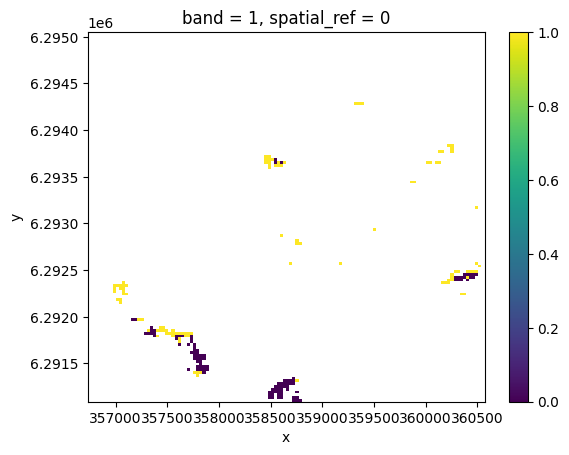

In [50]:
sam_bool.where(sam_bool != 255).plot()

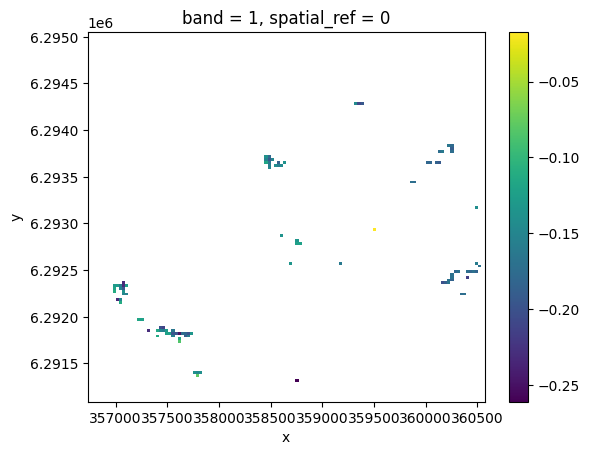

In [51]:
sam_mgs.plot()

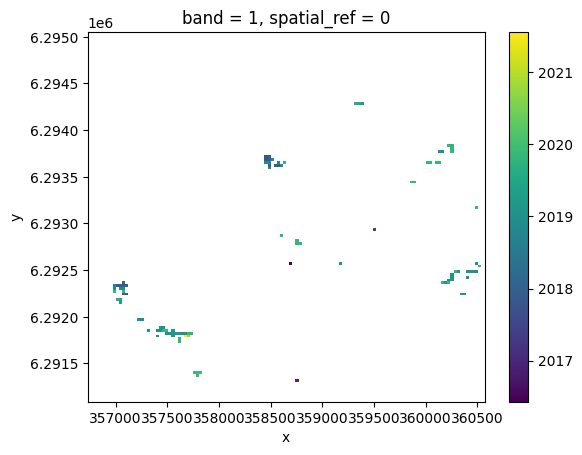

In [52]:
sam_dates.plot()

<br />

También podemos ejecutar la siguiente celda para visualizar el polígono de entrada.

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

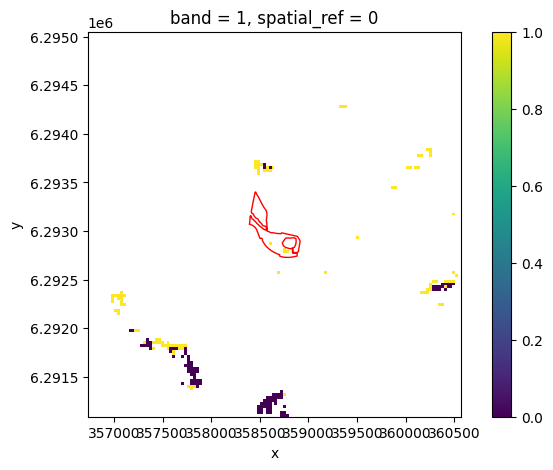

In [53]:
fig, ax = plt.subplots(figsize=(8, 5))
sam_bool.where(sam_bool != 255).plot.pcolormesh(x='x', y='y', ax=ax)
poly.plot(ax=ax, edgecolor='red', color='none')

<br />

Y hacer zoom al polígono.

(6292528.705270562, 6293600.400276449)

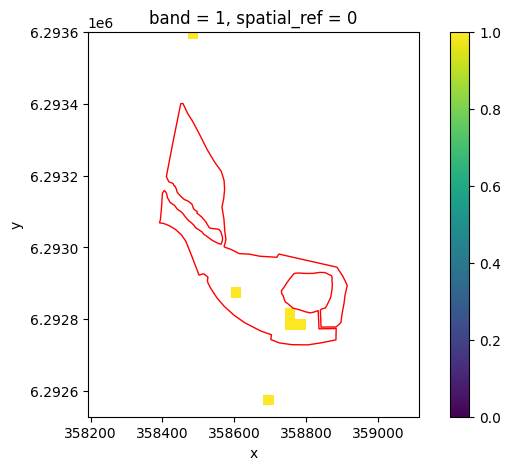

In [54]:
plot_xmin, plot_ymin, plot_xmax, plot_ymax = poly.buffer(distance = 200).total_bounds

fig, ax = plt.subplots(figsize=(8, 5))
sam_bool.where(sam_bool != 255).plot.pcolormesh(x='x', y='y', ax=ax)
poly.plot(ax=ax, edgecolor='red', color='none')

ax.set_xlim(plot_xmin, plot_xmax)
ax.set_ylim(plot_ymin, plot_ymax)

***
## Exportar imágenes

Finalmente, si queremos exportar los resultados anteriormente observados, debemos ejecutar la siguiente celda. Con ello, obtendremos 3 archivos cog (cloud optimized geotiff).

[COG](https://www.cogeo.org/) es un tipo especial de archivo de imagen raster (GeoTIFF) optimizada para operaciones en la nube.

In [55]:
out_folder = Path('outputs')
out_folder.mkdir(parents=True, exist_ok=True)

datacube.utils.cog.write_cog(
    geo_im = sam_bool,
    fname = out_folder / "sam_bool.tif",
    overwrite = True,
    nodata = 255,
    compress='LZW'
)

datacube.utils.cog.write_cog(
    geo_im = sam_mgs,
    fname = out_folder / "sam_mgs.tif",
    overwrite = True,
    nodata = np.nan,
    compress='LZW'
)

datacube.utils.cog.write_cog(
    geo_im = sam_dates,
    fname = out_folder / "sam_dates.tif",
    overwrite = True,
    nodata = np.nan,
    compress='LZW'
)

PosixPath('outputs/sam_dates.tif')

***
## Cerrar Data Cube Chile

Como buena práctica, recordemos ejecutaremos la siguiente celda para cerrar la conexión con Data Cube Chile antes de hacer "log out".

In [56]:
client.close()
cluster.close()